In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing as preproc
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import semopy
import random, sys
import warnings
warnings.filterwarnings('ignore')

import utils as ut

plt.style.use('default')
sns.set_palette("pastel")

r_seed = 4490907375869670109 #random.randrange(sys.maxsize)
print('seed:', r_seed)
# Good seed: 
# 4490907375869670109

# for reproducibility
# must to run this before create the BN! 
# Even in the cases where were changed the states names
gum.initRandom(0) 
random.seed(r_seed)

#print(gum.seed)

seed: 4490907375869670109


# Stroke Dataset

> https://www.kaggle.com/fedesoriano/stroke-prediction-dataset
    
Attribute Information
1. `id`: unique identifier
2. `gender`: "Male", "Female" or "Other"
3. `age`: age of the patient
4. `hypertension`: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5. `heart_disease`: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6. `ever_married`: "No" or "Yes"
7. `work_type`: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8. `residence_type`: "Rural" or "Urban"
9. `avg_glucose_level`: average glucose level in blood
10. `bmi`: body mass index
11. `smoking_status`: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12. `stroke`: 1 if the patient had a stroke or 0 if not

> Note: "Unknown" in smoking_status means that the information is unavailable for this patient

In [2]:
data_fn = 'data/stroke_clean_data.csv'
data = pd.read_csv(data_fn, index_col='id')
print('data size:', data.shape)
data.head()

data size: (3367, 11)


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


### Removing Outliers on Glucose level

https://www.cdc.gov/diabetes/basics/getting-tested.html

https://www.mymed.com/health-wellness/interesting-health-info/blood-sugar-levels/what-is-considered-a-normal-blood-sugar-level

**Fasting blood glucose level test**
- Normal (nondiabetic) person: 70–99 mg/dl (3.9–6 mmol/L)
- Recommendation for someone who is diabetic: 80–130 mg/dl (4.5–7.2 mmol/L)

**Two hours after a meal**
- Normal (nondiabetic) person: < 140 mg/dl (11 mmol/L)
- Recommendation for someone who is diabetic: < 180 mg/dl (10.0 mmol/L)

**Random blood sugar level test**

*A blood sample is taken at a random time, regardless of when the last meal was consumed.*
- Normal blood sugar reading: < 200mg/dl (or 11.1 mmol/L)

In [3]:
#data2 = data[(data['avg_glucose_level'] <= 150) & (data['stroke'] == 0)]
#data3 = data[data['stroke'] == 1]
#data = pd.concat([data2, data3], axis=0)

#### Selecting a subset

according to the variables selected

In [4]:
df = data[['age', 'hypertension', 
           'heart_disease', 'avg_glucose_level', 
           'stroke', 'gender',
           'smoking_status', 'bmi']].copy(deep=True)

df.shape

(3367, 8)

In [5]:
df.stroke.unique()

df[df.stroke == 0].count()

age                  3188
hypertension         3188
heart_disease        3188
avg_glucose_level    3188
stroke               3188
gender               3188
smoking_status       3188
bmi                  3188
dtype: int64

In [6]:
#df['gender'].summary()

no_stroke, yes_stroke = df[df.stroke == 0].count().stroke, df[df.stroke == 1].count().stroke
print('No-Stroke: %d\nStroke: %d\nTotal: %d' % ((no_stroke, yes_stroke, no_stroke+yes_stroke)))

No-Stroke: 3188
Stroke: 179
Total: 3367


## Sampling $\rightarrow$ Balancing

https://stackoverflow.com/a/63311258/998341

https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html#imblearn.under_sampling.RandomUnderSampler.fit_resample

In [7]:
rus = RandomUnderSampler(sampling_strategy='not minority', random_state=1)
df_balanced, balanced_labels = rus.fit_resample(df, df['stroke'])


# OverSampling: 
# https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html#imblearn.over_sampling.RandomOverSampler
#rus = RandomOverSampler(sampling_strategy='not minority', random_state=1)
#df_balanced, balanced_labels = rus.fit_resample(df, df['stroke'])

df_balanced['stroke'] = balanced_labels

print(df_balanced.shape)
print(balanced_labels.shape)

(358, 8)
(358,)


In [8]:
# original dataset
print(df.shape)
df.head()

(3367, 8)


,age,hypertension,heart_disease,avg_glucose_level,stroke,gender,smoking_status,bmi
id,,,,,,,,
9046,67.0,0,1,228.69,1,Male,formerly smoked,36.6
31112,80.0,0,1,105.92,1,Male,never smoked,32.5
60182,49.0,0,0,171.23,1,Female,smokes,34.4
1665,79.0,1,0,174.12,1,Female,never smoked,24.0
56669,81.0,0,0,186.21,1,Male,formerly smoked,29.0


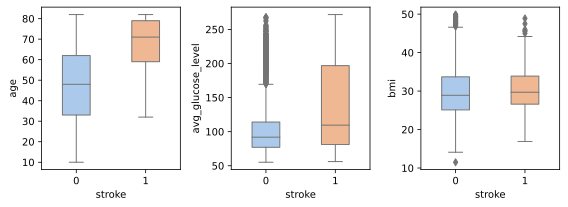

In [9]:
plt.figure(figsize=(8,3))

plt.subplot(1,3,1)
sns.boxplot(data=data,  y='age', x='stroke', width=0.4, linewidth=1)

plt.subplot(1,3,2)
sns.boxplot(data=data,  y='avg_glucose_level', x='stroke', width=0.4, linewidth=1)

plt.subplot(1,3,3)
sns.boxplot(data=data,  y='bmi', x='stroke', width=0.4, linewidth=1);

plt.tight_layout()

### Organizing the data to `Semopy` and `PyAgrum`

> `PyAgrum` works with `labeled` variables but `Semopy` doesn't

In [10]:
# Semopy
df_semopy = df_balanced.copy(deep=True)

le = preproc.LabelEncoder()
df_semopy['gender'] = le.fit_transform(df_balanced.gender.values)
print(df.gender.unique(), '-->', df_semopy.gender.unique())

df_semopy['smoking_status'] = le.fit_transform(df_balanced.smoking_status.values)
print(df.smoking_status.unique(), '-->', df_semopy.smoking_status.unique())

# Bayesian Net 
df_bn = df.copy(deep=True)
df_bn['stroke'].replace(to_replace=[0, 1], value=['no', 'yes'], inplace=True)
df_bn['hypertension'].replace(to_replace=[0, 1], value=['no', 'yes'], inplace=True)
df_bn['heart_disease'].replace(to_replace=[0, 1], value=['no', 'yes'], inplace=True)

['Male' 'Female'] --> [1 0]
['formerly smoked' 'never smoked' 'smokes'] --> [1 0 2]


In [11]:
df_semopy.head()

,age,hypertension,heart_disease,avg_glucose_level,stroke,gender,smoking_status,bmi
0,80.0,1,0,232.12,0,1,1,28.8
1,78.0,0,0,143.47,0,1,0,27.6
2,74.0,0,0,65.28,0,1,1,28.2
3,79.0,0,1,67.84,0,0,2,25.2
4,27.0,0,0,95.10,0,1,0,24.3


In [12]:
df_bn.head()

,age,hypertension,heart_disease,avg_glucose_level,stroke,gender,smoking_status,bmi
id,,,,,,,,
9046,67.0,no,yes,228.69,yes,Male,formerly smoked,36.6
31112,80.0,no,yes,105.92,yes,Male,never smoked,32.5
60182,49.0,no,no,171.23,yes,Female,smokes,34.4
1665,79.0,yes,no,174.12,yes,Female,never smoked,24.0
56669,81.0,no,no,186.21,yes,Male,formerly smoked,29.0


In [13]:
#df.to_csv(data_fn)
#df = pd.read_csv(data_fn, index_col='id')

In [14]:
#g = sns.pairplot(df_semopy,hue = 'stroke', diag_kind= 'hist',
#             vars=df_semopy.columns[:],
#             plot_kws=dict(alpha=0.5), 
#             diag_kws=dict(alpha=0.5))
#g.fig.set_size_inches(5,5)

#g.savefig('data_analysis.png')

# SEM

## Model 2, without `heart_disease`

In [15]:
# heart_disease ~ age + bmi + smoking_status + avg_glucose_level + hypertension \n

desc = '''
        stroke ~ age + avg_glucose_level + hypertension
        hypertension ~ bmi + smoking_status + age
        V1 =~ hypertension + age
        V2 =~ avg_glucose_level + bmi
        avg_glucose_level ~ bmi
        age ~~ avg_glucose_level
        '''

mod2 = semopy.Model(desc)
res = mod2.fit(df_semopy)

stats = semopy.calc_stats(mod2)
stats.T

,Value
DoF,3.000000
DoF Baseline,16.000000
chi2,12.317320
chi2 p-value,0.006372
chi2 Baseline,324.456881
CFI,0.969794
GFI,0.962037
AGFI,0.797531
NFI,0.962037
TLI,0.838900


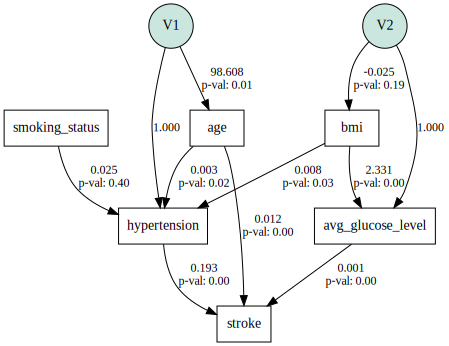

In [16]:
# saving detailed assessment
semopy.report(mod2, 'output/StrokeModelSpecialist2')

semopy.semplot(mod2, 'output/sem-stroke-specialist2.svg', plot_covs=False, plot_exos=True)

# Bayesian Network

In [17]:
df_bn.head()

,age,hypertension,heart_disease,avg_glucose_level,stroke,gender,smoking_status,bmi
id,,,,,,,,
9046,67.0,no,yes,228.69,yes,Male,formerly smoked,36.6
31112,80.0,no,yes,105.92,yes,Male,never smoked,32.5
60182,49.0,no,no,171.23,yes,Female,smokes,34.4
1665,79.0,yes,no,174.12,yes,Female,never smoked,24.0
56669,81.0,no,no,186.21,yes,Male,formerly smoked,29.0


In [18]:
# setting the correct data type
df_bn['smoking_status'] = df_bn['smoking_status'].astype('str')
df_bn['hypertension'] = df_bn['hypertension'].astype('str')
df_bn['stroke'] = df_bn['stroke'].astype('str')
df_bn['heart_disease'] = df_bn['heart_disease'].astype('str')
df_bn['age'] = df_bn['age'].astype('int')

df_bn.rename(columns = {'avg_glucose_level':'glucose'}, inplace=True)

In [19]:
df_bn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3367 entries, 9046 to 37544
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             3367 non-null   int32  
 1   hypertension    3367 non-null   object 
 2   heart_disease   3367 non-null   object 
 3   glucose         3367 non-null   float64
 4   stroke          3367 non-null   object 
 5   gender          3367 non-null   object 
 6   smoking_status  3367 non-null   object 
 7   bmi             3367 non-null   float64
dtypes: float64(2), int32(1), object(5)
memory usage: 352.6+ KB


## BN1, with `heart_disease`

In [20]:
nodes = ['age', 'bmi', 'smoking_status',
         'glucose', 'hypertension', 'stroke', 
         'heart_disease']

bn1 = gum.BayesNet("Stroke")

for n in nodes:
    #_ = bn.add(gum.LabelizedVariable(n, n, np.min(df[n]), np.max(df[n])))
    print('--> ', n)
    if (n in ['smoking_status', 'hypertension', 'stroke', 'heart_disease']):
        _ = bn1.add(gum.LabelizedVariable(n, n, df_bn[n].unique().tolist()))
    elif (n == 'glucose'):
        # max of glucose is ~271
        n_bins = np.arange(0,290, 10)
        _, bins = np.histogram(df_bn.glucose, bins=n_bins)
        bins = [float(b) for b in bins]
        _ = bn1.add(gum.DiscretizedVariable(n, n, bins))
    elif (n == 'bmi'):
        n_bins = np.arange(0,60, 10)
        _, bins = np.histogram(df_bn.bmi, bins=n_bins)
        bins = [float(b) for b in bins]
        _ = bn1.add(gum.DiscretizedVariable(n, n, bins))
    elif (n == 'age'):
        n_bins = np.arange(0,110, 10)
        _, bins = np.histogram(df_bn.age, bins=n_bins)
        bins = [float(b) for b in bins]
        _ = bn1.add(gum.DiscretizedVariable(n, n, bins))
    else:
        _ = bn1.add(gum.DiscretizedVariable(n, n, df_bn[n].unique().tolist()))

for n in nodes:
    if (n == 'bmi'):
        bn1.addArc(n, 'heart_disease')
        bn1.addArc(n, 'glucose')
        bn1.addArc(n, 'hypertension')
    if (n == 'smoking_status'):
        bn1.addArc(n, 'heart_disease')
        bn1.addArc(n, 'hypertension')
    if (n == 'age'):
        bn1.addArc(n, 'heart_disease')
        bn1.addArc(n, 'stroke')
        bn1.addArc(n, 'hypertension')
    if (n == 'glucose'):
        bn1.addArc(n, 'heart_disease')
        bn1.addArc(n, 'stroke')
    if (n == 'hypertension'):
        bn1.addArc(n, 'heart_disease')
        bn1.addArc(n, 'stroke')
    # MAYBE
    #if (n == 'heart_disease'):
    #    bn.addArc(n, 'stroke')

# randomly create the CPTs
bn1.generateCPTs()

-->  age
-->  bmi
-->  smoking_status
-->  glucose
-->  hypertension
-->  stroke
-->  heart_disease


#### Priors

In [21]:
# Age
age_n_bins = np.arange(0,110, 10)
age_bin_v, age_bins = np.histogram(df_bn.age, bins=age_n_bins)
bn1.cpt('age')[:] = age_bin_v

# BMI
bmi_n_bins = np.arange(0,60, 10)
bmi_bin_v, bmi_bins = np.histogram(df_bn.bmi, bins=bmi_n_bins)
bn1.cpt('bmi')[:] = bmi_bin_v

#gnb.sideBySide(bn1, gnb.getInference(bn1))
#bn

#### Info

https://www.cdc.gov/diabetes/managing/manage-blood-sugar.html
- Safer **glucose level**: 80-180.


In [22]:
#df.to_csv('./data/stroke_clean_data2.csv')

#df_bn['bmi'] = df_bn['bmi'].astype(int)

df_bn[nodes].to_csv('./data/stroke_clean_data_bn.csv', index=False, quoting=2)

In [23]:
# using bn as template for variables
learner = gum.BNLearner('data/stroke_clean_data_bn.csv', bn1)

# https://pyagrum.readthedocs.io/en/0.22.3/BNLearning.html#learning
learner.useEM(epsilon=1e-10)

# solves the resolution problem. Neil & Fenton book p. 606
# https://en.wikipedia.org/wiki/Additive_smoothing
learner.useAprioriSmoothing(1e-10)

bn12 = learner.learnParameters(bn1.dag())

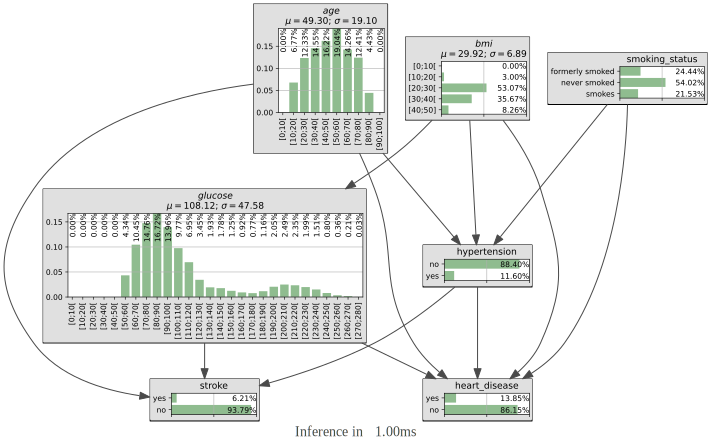

In [24]:
gnb.showInference(bn12, size='10')

## BN, without `heart_disease`

In [25]:
nodes = ['age', 'bmi', 'smoking_status',
         'glucose', 'hypertension', 'stroke']

bn2 = gum.BayesNet("Stroke")

for n in nodes:
    #_ = bn.add(gum.LabelizedVariable(n, n, np.min(df[n]), np.max(df[n])))
    print('--> ', n)
    if (n in ['smoking_status', 'hypertension', 'stroke']):
        _ = bn2.add(gum.LabelizedVariable(n, n, df_bn[n].unique().tolist()))
    elif (n == 'glucose'):
        # max of glucose is ~271
        n_bins = np.arange(0,290, 10)
        _, bins = np.histogram(df_bn.glucose, bins=n_bins)
        bins = [float(b) for b in bins]
        _ = bn2.add(gum.DiscretizedVariable(n, n, bins))
    elif (n == 'bmi'):
        n_bins = np.arange(0,60, 10)
        _, bins = np.histogram(df_bn.bmi, bins=n_bins)
        bins = [float(b) for b in bins]
        _ = bn2.add(gum.DiscretizedVariable(n, n, bins))
    elif (n == 'age'):
        n_bins = np.arange(0,110, 10)
        _, bins = np.histogram(df_bn.age, bins=n_bins)
        bins = [float(b) for b in bins]
        _ = bn2.add(gum.DiscretizedVariable(n, n, bins))
    else:
        _ = bn2.add(gum.DiscretizedVariable(n, n, df_bn[n].unique().tolist()))

for n in nodes:
    if (n == 'bmi'):
        bn2.addArc(n, 'glucose')
        bn2.addArc(n, 'hypertension')
    if (n == 'smoking_status'):
        bn2.addArc(n, 'hypertension')
    if (n == 'age'):
        bn2.addArc(n, 'stroke')
        bn2.addArc(n, 'hypertension')
    if (n == 'glucose'):
        bn2.addArc(n, 'stroke')
    if (n == 'hypertension'):
        bn2.addArc(n, 'stroke')

# randomly create the CPTs
#bn2.generateCPTs()

-->  age
-->  bmi
-->  smoking_status
-->  glucose
-->  hypertension
-->  stroke


#### Priors

In [26]:
# Age
age_n_bins = np.arange(0,110, 10)
age_bin_v, age_bins = np.histogram(df_bn.age, bins=age_n_bins)
bn2.cpt('age')[:] = age_bin_v

# BMI
bmi_n_bins = np.arange(0,60, 10)
bmi_bin_v, bmi_bins = np.histogram(df_bn.bmi, bins=bmi_n_bins)
bn2.cpt('bmi')[:] = bmi_bin_v

#gnb.sideBySide(bn2, gnb.getInference(bn2))
#bn

#### Info

https://www.cdc.gov/diabetes/managing/manage-blood-sugar.html
- Safer **glucose level**: 80-180.


In [27]:
#df.to_csv('./data/stroke_clean_data2.csv')
#df_bn[nodes].to_csv('./data/stroke_clean_data_bn.csv', index=False, quoting=2)

In [28]:
# using bn as template for variables
learner = gum.BNLearner('data/stroke_clean_data_bn.csv', bn2)

# https://pyagrum.readthedocs.io/en/0.22.3/BNLearning.html#learning
learner.useEM(epsilon=1e-10)

# solves the resolution problem. Neil & Fenton book p. 606
# https://en.wikipedia.org/wiki/Additive_smoothing
learner.useAprioriSmoothing(1e-10)

bn22 = learner.learnParameters(bn2.dag())

ut.BayesNet2Img(bn22, 'output/bn22-no-heart-disease.svg')

--> File "output/bn22-no-heart-disease.svg" saved!


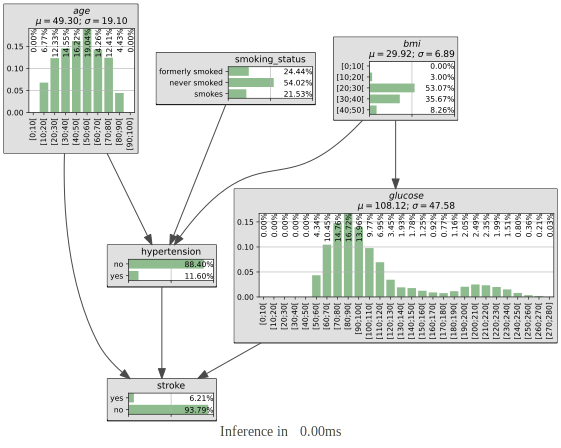

In [29]:
gnb.showInference(bn22, size='10')

## Inference

- `bn12`: with `heart_disease` (`b1` not trained)
- `bn22`: without `heart_disease` (`b2` not trained)

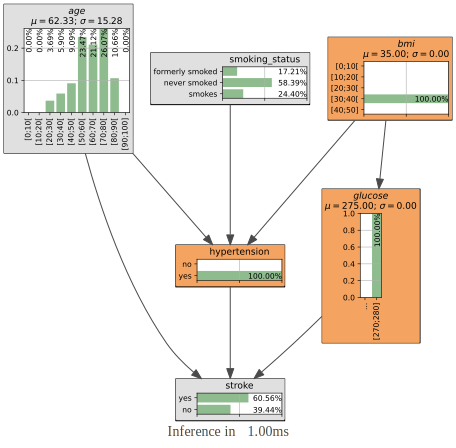

In [30]:
#gnb.showInference(bn12, size='10', evs={'age':3, 'bmi':4, 'smoking_status':2})
#gnb.showInference(bn2, size='10', evs={'age':8, 'bmi':4, 'smoking_status':2})

# Dr. Almekhlafi confirmed this scenario (using net #2 not #22): slightly pos to STROKE
evs={'bmi':3, 'glucose': 27, 'hypertension':1}

# fist row of data, positive to STROKE
#evs={'age':6, 'bmi':3, 'hypertension':0, 'smoking_status': 0, 'glucose': 22}

#evs={'stroke':1}

gnb.showInference(bn22, size='10', evs=evs)

#gnb.sideBySide(gnb.showInference(bn12, size='5', evs=evs),
#               gnb.showInference(bn22, size='5', evs=evs))

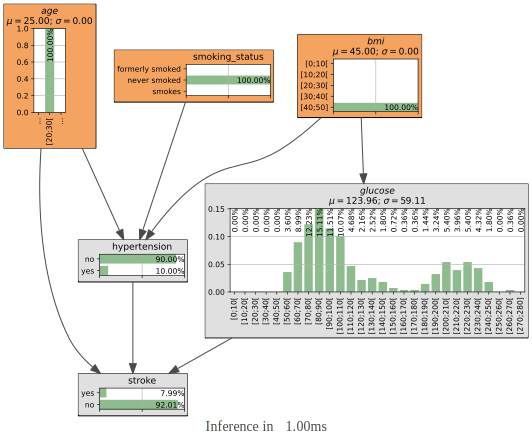

In [33]:
gnb.showInference(bn22, size='10', evs={'age':2, 'bmi':4, 'smoking_status':1})

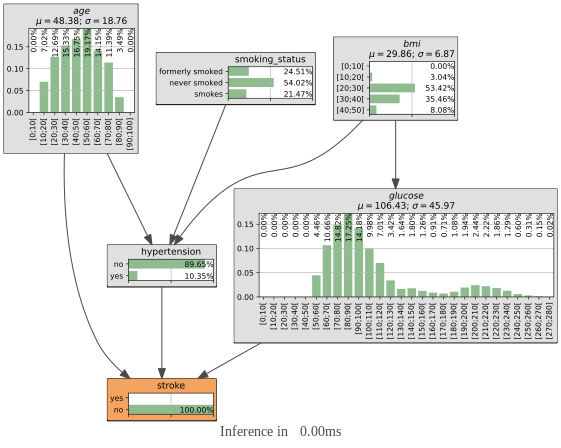

In [34]:
gnb.showInference(bn22, size='10', evs={'stroke':1})